# Ex: Image Classification via Logistic Regression

We will now learn how to use a linear _classifier_ (Logistic Regression) to address an image recognition problem.

Logistic regression assumes that the probability of a (binary) event is given by the expression:

$$
p(x) = \frac{1}{1 + e^{-{\bf w} \cdot {\bf x}}}
$$

Where $\bf w$ is a vector of weights, $\bf x$ is a vector of independent variables (or features), and ${\bf w} \cdot {\bf x}$ is their inner product:

$$
{\bf w} \cdot {\bf x} = \sum_{i = 1}^{n} w_i x_i
$$

Assuming that the probability $p(x)$ is the quantity that we want to estimate, the expression can be rewritten as:

$$
\log\left(\frac{p(x)}{1 + p(x)}\right) = \sum_{i = 1}^{n} w_i x_i
$$

The trick is that in practice $p(x)$ is just the class label, which can be interpreted as a probability: in particular $p(x) = 1$ for the "positive" class and $p(x) = 0$ for the "negative" class. Since the label $p(x)$ is know, the left-most expression in the above equation can be computed off-line, leading to a simple linear model.

Intuitively, as the sum $\sum_{i = 1}^{n} w_i x_i$ grows, the odds that the class is positive increase according to a sigmoid curve:

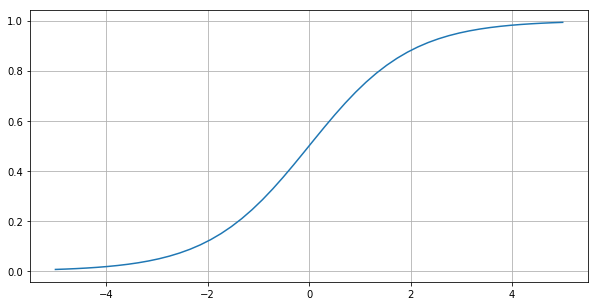

In [2]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
x = np.linspace(-5, 5)
plt.plot(x, 1 / (1 + np.exp(-x)))
plt.grid()
plt.show()

In principle we could use the linear least sqaures methods to fit:

$$
\log\left(\frac{p(x)}{1 + p(x)}\right) = \sum_{i = 1}^{n} w_i x_i
$$

In practice, however, it does not make sense, since we are know dealing with probabilities. Instead, we focus on choosing weights the [maximize the likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of observing the known data.

Here, we will rely on scikit-learn to take care of maximum likelyhood estimation: the module provides access to different solver that can handle maximum likelyhood estimation with L1 and L2 penalties.

We will use the MNIST dataset as a benchmark: the MNIST images represent numerical digits, hence we have 10 classes (0..9). The images have a fixed format (28x28 pixels), which is good, because the input size for a NN should always be constant. If we wanted to classify a larger image we would be forced to rescale it to the size that the network expects (i.e. 28x28).

Before the true action can start we need to undertstand the code, and the data that we are dealing with.

## First of All...

If you are using this notebook from Google Colab, you need to fetch the necessary resources by running:

In [ ]:
!mkdir resources
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab02/resources/AirQualityUCI.csv
!mv AirQualityUCI.csv resources
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab02/resources/lr_train.txt
!mv lr_train.txt resources/
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab02/resources/lr_test.txt
!mv lr_test.txt resources/
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab02/lutil.py

## Loading the Data

Scikit-learn provides automated access to a small selection of commonly used datasets, which include MNIST. Hence, importing the data in our case is super-simple:

In [3]:
import numpy as np
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='resources')
index = np.arange(len(mnist.data))
np.random.seed(100)
np.random.shuffle(index)
train_idx, test_idx = index[:60000], index[60000:]
x_train, x_test = mnist.data[train_idx], mnist.data[test_idx]
y_train, y_test = mnist.target[train_idx], mnist.target[test_idx]
y_train, y_test = y_train.astype(int), y_test.astype(int)

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


The MNIST data is now stored in a two pairs of numpy arrays:

* The `x_train` and `x_test` arrays (input) contain the greyscale value of each pixel (the matrix is store as a single sequence)
* The `y_train` and `y_test` arrays (input) contain the class as an integer (i.e. the represented digit)

Let's try and see the size of `x_train`:

x_train.shape

60000 is the dataset size, the two 28s are respective the width and height of the images.

We can also view the first item in the vector (reshaped as a 28x28 matrix):

In [4]:
print(x_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  38 163 255 254 254 176  47   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  12 113 243 253 254 253 253 253 247  53
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  68 253 253 240  69  36 222 253 253 231  93   0   

Well, that was not very helpful... The only clear thing is that the greyscale data is stored using integer numbers. In particular, we are using numbers between 0 and 255 (i.e. one byte).

But this is an image, right? We we _should_ be able to display it. We can do it via the `imshow` function in matplotlib.

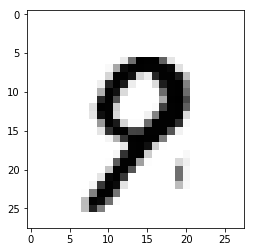

In [5]:
from matplotlib import pyplot as plt

plt.figure()
plt.imshow(x_train[0].reshape(28, 28), cmap='Greys')
plt.show()

Good: that's much clearer now! The "Greys" passed via the `cmap` parameters tells matplotlib that the numbers should rendered using a scale of grey hues.

And what about the classes? Let's inspect the `y_train` array:

In [6]:
print(y_train[0:4])

[9 1 3 2]


The classes are just integers, each representing the corresponding digit.

## Preprocessing

As usual, before we can start with the training we need to do a little bit of preprocessing. Specifically, we need to normalize the input.

In [7]:
# Normalize the input data
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

## The Actual Model

We can now build a first model. Full training would requires quite some time, so we limit the number of iterations and we reduce the tolerance:

In [8]:
from sklearn import linear_model

model = linear_model.LogisticRegression(solver='saga', tol=1e-4, max_iter=10)
model.fit(x_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

Let's think about something: we have originally described logistic regression for binary classification, but we have 10 classes here (one per digit).

How does logistic regression handle this?

A first method consists in turnining a single classification problem with $n$ classes into $n$ classification problems. Within each problem, the goal is to separate the considered class from all the others. This is the default behavior in scikit-learn. At prediction time, each classifier will output a probability and the class with the highest probability will "win".

We can now evaluate the performance of the model. The actual output of the classifier is a set of probabilities, i.e.

In [9]:
pred_train = model.predict_proba(x_train)
pred_train[:2]

array([[1.46767226e-04, 6.48465031e-08, 8.49870118e-04, 1.95823172e-04,
        6.86001800e-03, 6.35925639e-04, 9.98539190e-07, 7.79310125e-02,
        2.31164305e-02, 8.90263089e-01],
       [1.26951352e-06, 8.36044232e-01, 2.51273565e-03, 5.55720635e-02,
        1.00910691e-04, 1.02084983e-02, 6.19372001e-03, 3.14527520e-03,
        5.40107177e-02, 3.22105772e-02]])

We can convert the probabilities in a single class by taking the maximum. Scikit-learn can do this for us:

In [10]:
pred_train = model.predict(x_train)
print(y_train[:2])
print(pred_train[:2])

[9 1]
[9 1]


Next, we can compute the accuracy on the training and the test set:

In [11]:
from sklearn import metrics

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

acc_train = metrics.accuracy_score(y_train, pred_train)
acc_test = metrics.accuracy_score(y_test, pred_test)

print('Accuracy on the training set: %f' % acc_train)
print('Accuracy on the test set: %f' % acc_test)

Accuracy on the training set: 0.920467
Accuracy on the test set: 0.912600


Which is very good!

Let's get a little bit more into the details.

By default (as we mentioned), scikit-learn employs adopt a "one vs other" scheme. This means that in practice we are training 10 different Logistic Regression classifiers, one per class.

It is also possible to perform a so-called multinomial logistic regression, where the optimizer is made aware that the are multiple (unordered) classes:

In [12]:
model = linear_model.LogisticRegression(solver='saga', tol=1e-4, max_iter=10, multi_class='multinomial')
model.fit(x_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

Let's see the new accuracy:

In [13]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

acc_train = metrics.accuracy_score(y_train, pred_train)
acc_test = metrics.accuracy_score(y_test, pred_test)

print('Accuracy on the training set: %f' % acc_train)
print('Accuracy on the test set: %f' % acc_test)

Accuracy on the training set: 0.933033
Accuracy on the test set: 0.922300


Slighly better!

Since we are dealing with images, the coefficients can be interpreted in terms of sensitivity to each pixel. This allows us to plot the coefficient as an "mask" which visually depicts which pixel each terms of the Logistic Regressor output is looking for:

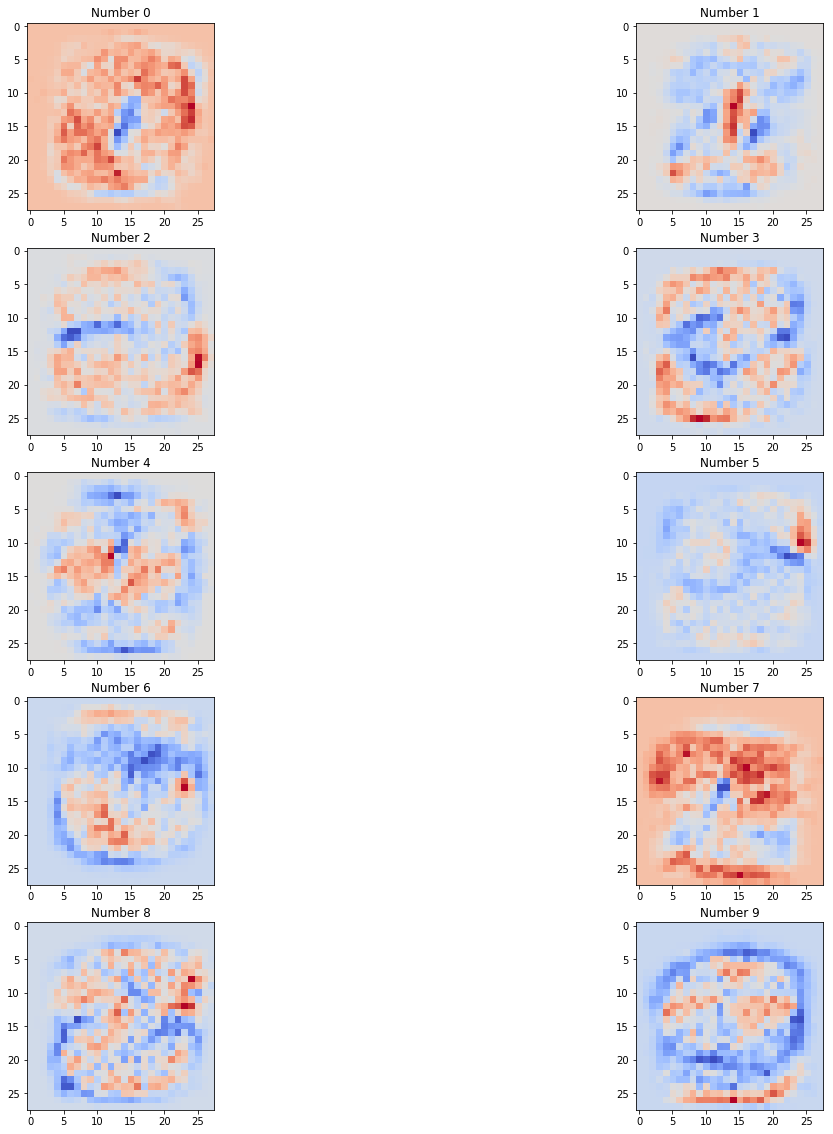

In [14]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.title('Number %d' % i)
    plt.imshow(model.coef_[i].reshape(28, 28), cmap='coolwarm')
plt.show()